# Time surfaces

We will now explore the use of temporal dynamics of Leaky Integrators to address time domain problems.

In the spatial domain, one can use the convolution operation to create neurons that respond to the activity of a specific region of the input signal, called receptive field. The neurons will be higly active if the input pattern within the receptive field matches the kernel of the convolution. In the temporal domain, these neurons can respond to temporal characteristics as well, such as the velocity of the moving pattern.

To see how we can exploit such dynamics, we will implement a  model that can detect disks that move with different velocities.

### Task 0: Importing the libraries

We begin by importing the necessary libraries for our implementation, such as norse, torch and libraries to help us fetch and vsualize our data.

In [ ]:
!pip install norse

import norse
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from urllib.request import urlretrieve

### Task 1: Preprocessing the dataset

Let's begin by obtaining and understanding the data. The data cosnist of events genetared from the motion of three disks in parallel in three different velocities. For this task, the polarity of the data has been ignored. Both the positive and negative polarity are considered the same and the data have the format (time, x, y).


#### Task 1.1: Loading the dataset

The data are saved as a [sparse tensor](https://pytorch.org/docs/stable/sparse.html). This representation allows for memory efficient storage of the data but it is not so friendly to work with. You can convert it back to a dense tensor using `.to_dense()`.

In [ ]:
data_file, _ = urlretrieve("https://github.com/ncskth/phd-course/raw/main/book/module3/2404_circle.dat")
data = torch.load(data_file)
print(data.shape)
print(data)

# convert data to dense tensor
# data = ...

# print(data.shape)
# print(data)

What is the difference in the shape and representation of the sparse and the dense tensor?

#### Task 1.2: Visualization

In order to understand the data that we are working with, it is ofter very useful to visualize it. Use the `animate_frames` function provided below to animate the input data.

In [ ]:
def animate_frames(frames, figure=None, interval: int = 20, **kwargs):
    if figure is None:
        figure, _ = plt.subplots(**kwargs)
    ax = figure.gca()

    image = ax.imshow(frames[0])  # .T)
    ax.set_axis_off()

    def animate(index):
        image.set_data(frames[index])  # .T)
        return image

    anim = FuncAnimation(figure, animate, frames=len(frames), interval=interval)
    video = anim.to_html5_video()
    html = HTML(video)
    display(html)
    plt.tight_layout()
    plt.close()



def events_to_frames(frames, polarity: bool = False):
    if len(frames.shape) == 3:
        frames = frames.unsqueeze(-1).repeat(1, 1, 1, 3)
    else:
        if not polarity:
            frames = frames.abs().sum(-1)
        elif polarity:
            frames = torch.concat([frames, torch.zeros(frames.shape[0], 1, *frames.shape[2:], device=frames.device)], dim=1).movedim(1, -1)
    frames = ((frames / frames.max()) * 255).int().clip(0, 255)
    return frames

In [ ]:
# Visualize your data
# ...

### Task 2: Model Implementation

To solve this task, you will need to create a simple network to extract the position of the three disks that differ in velocity. The model should identify the position of the disks and the speed regime (slow, medium, fast) of their motion.


#### Task 2.1: 2d convolutional kernel

As a first step, you can perform a [2-dimenstional convolution](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).
The convolution operation can be thought as pettern matching of the input with the kernel. The kernel is applied at every pixel of the input and the resulting value indicates how much the kernel matches the input at that position.

To locate the position of the disks in space, you need to implement a kernel the shape of the disk (the ratio of the disk is 5 pixels.)
It might be of help to fill the inner circle with zeros or negative values to avoid spurious activity.

You can always come back and tune your kernel!

Note that the weight matrix for the `Conv2d` layer should be 4-dimensional. (Why?)

[torch.Tensor.unsqueeze_](https://pytorch.org/docs/stable/generated/torch.Tensor.unsqueeze_.html) and [torch.meshgrid](https://pytorch.org/docs/stable/generated/torch.meshgrid.html) could be useful for this task.

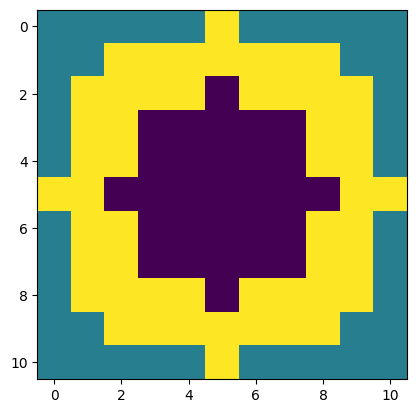

In [ ]:
def circular_kernel(radius):
  # Implementation of a circular kernel to detect the moving disk
  pass

radius = 5
circular_kernel_tensor = circular_kernel(radius)
#plt.imshow(circular_kernel_tensor[0][0])

####Task 2.2: Temporal channels

Now that you have your spatial computing layer, you can work on the temporal units. You  should use  LIFBoxCell neurons for your network. The output of the convolution can then be fed into three neuron layers (channels), operating in parallel, with different temporal dynamics.

To implement your network, you can create a module that inherits from [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). You can define the `forward` function to perform the convolution and feed its output to the three LIFBoxCell neuron layers.
The model should output the response of these temporal layers. Each layer should be tuned to respond to different regimes of speed.
You are advised to tune both the `tau_mem_inv` and `v_th` values of your parameters.

In [ ]:
class Network(torch.nn.Module):
  def __init__(self):
    super().__init__()

    # correct the Conv2d() layer to have the correct number of input/output channels, kernel size, padding and bias settings
    self.conv = torch.nn.Conv2d()
    self.conv.weight.data = circular_kernel_tensor

    # create the 3 different neuron layers to capture the disks
    # self.parameters_1 = ...
    # self.temporal_layer_1 = ...

    # self.parameters_2 = ...
    # ...

  def forward(self, input):
    state_1, state_2, state_3 = None, None, None
    response_1, response_2, response_3 = [], [], []
    for x in range(input.shape[0]):
      # fill in the forward pass of each time step

      # x = ...

      pass

    return response_1, response_2, response_3


net = Network()
response_1, response_2, response_3 = net(data.float())


#### Task 2.3: Visualize your results

To understand how the network behaves, it would be wise to visualize its output as a video. Using the `animate_frames` function provided in Task 1.2, visualize your results.

To better visualize your results you could create a single animation and superimpose the activations of your model.

<br>

What do you observe? Is it possible to create selective neuron layers for all three different velocities?

In [ ]:
# Visualize your results

# animate input data
# animate response 1
# animate response 2
# animate response 3

# OR

# animate input data superimposing the model's response

### Task 3 (Optional): Velocity selectivity

In the previous implementation, the neurons are selective to velocities above certain thresholds. However, we might want the neurons to be responsive to a bounded range of velocities, while staying silent on higher or lower speeds. To work around this issue, we will try to modify the initial network to suppress undesired activity.

#### Task 3.1: Inhibition

In your model, there might have been unwanted activation in the 3 `LIFBoxCell` channels. Try to modify the forward pass of your model to inhibit such undesired activations. You can use the information of the other neurons' activity to inhibit certain channels of neurons.

In [ ]:
class Network2(torch.nn.Module):
  def __init__(self):
    super().__init__()
    # use the same network architecture as in Task 2.2
    pass

  def forward(self, input):
    # perform the inhibition process
    pass

Visualize your results. How does the inhibition process affect the model's performance?

In [ ]:
# Visualize your results
# ...

#### Task 3.2: Finetune model architecture

No model is perfect! In your implementation, you might observe spurious activity away from the center of the disks as a result of the convolution operation. To suppress such activity, you can add a second layer that performs a smoothing operation. In this layer, you can use a convolution, such as a smoothing kernel, that is selective for activations in the center of the kernel with negative values in the surroundings. This will allow only for the most active regions, i.e. the center of the disks, to propagate events.

You are encouraged to test different architectures and connectivities.